<a href="https://colab.research.google.com/github/spsgim/Titanic_Machine_Learning_from_Disaster/blob/main/Titanic_Machine_Learning_from_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

# Importing Datasets

In [2]:
!git clone https://github.com/spsgim/Titanic_Machine_Learning_from_Disaster.git

Cloning into 'Titanic_Machine_Learning_from_Disaster'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (5/5), 34.02 KiB | 1.79 MiB/s, done.


In [3]:
train_data = pd.read_csv('/content/Titanic_Machine_Learning_from_Disaster/train.csv')
train_data.shape

(891, 12)

In [4]:
test_data = pd.read_csv('/content/Titanic_Machine_Learning_from_Disaster/test.csv')
test_data.shape

(418, 11)

In [5]:
gender_submission = pd.read_csv('/content/Titanic_Machine_Learning_from_Disaster/gender_submission.csv')
gender_submission.shape

(418, 2)

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Missing Values Treatment

In [7]:
train_data.isna().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [8]:
age_means_train = train_data.groupby(['Survived', 'Sex', 'Pclass'])['Age']
train_data['Age'].fillna(age_means_train.transform('mean'), inplace =True)
test_data['Age'].fillna(age_means_train.transform('mean'), inplace =True)

In [9]:
train_data['IsCabin'] = train_data['Cabin'].notna().astype('int')
test_data['IsCabin'] = test_data['Cabin'].notna().astype('int')
train_data.drop('Cabin', axis=1, inplace = True)
test_data.drop('Cabin', axis=1, inplace = True)

In [10]:
train_data.dropna(inplace=True)

In [11]:
train_data.isna().sum().sum()

0

In [12]:
test_data.isna().mean()*100

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.239234
Embarked       0.000000
IsCabin        0.000000
dtype: float64

In [13]:
test_data['Fare'].fillna(train_data['Fare'].median(), inplace=True)

In [14]:
test_data.isna().sum().sum()

0

# Outliers

In [15]:
sns.set_palette(palette="Set2",n_colors=18)
sns.set_style("whitegrid", {'axes.facecolor': '0.97'})

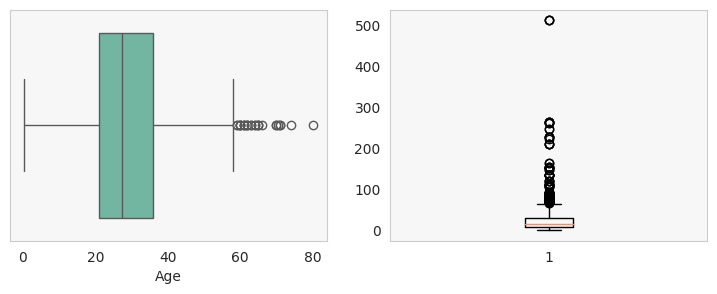

In [16]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
sns.boxplot(x = train_data['Age'])
plt.grid(False)
plt.subplot(1,2,2)
plt.boxplot(x = train_data['Fare'])
plt.grid(False)

In [17]:
# Treatment with IQR method
def outliers_treatment(df, var):
  for v in var:
    q1 = df[v].quantile(.25)
    q3 = df[v].quantile(.75)
    iqr = q3-q1
    upper_limit = q3 + 1.5*iqr

    print(f'Upper Limit for {v}: {upper_limit}')

    df.loc[df[v] > upper_limit, v] = upper_limit

  return df

In [18]:
outliers_treatment(train_data, ['Age', 'Fare'])

Upper Limit for Age: 58.5
Upper Limit for Fare: 65.6563


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,IsCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,65.6563,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,23.818182,1,2,W./C. 6607,23.4500,S,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C,1


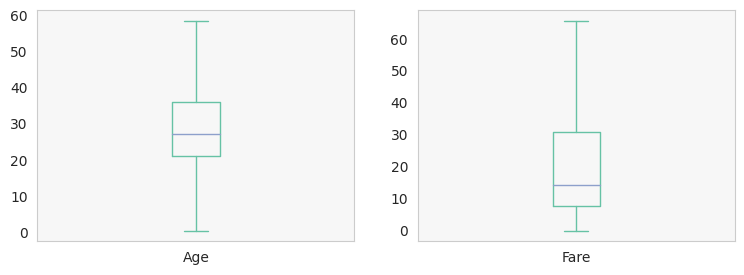

In [19]:
plt.figure(figsize=(9, 3))
plt.subplot(1,2,1)
train_data['Age'].plot(kind='box')
plt.grid(False)
plt.subplot(1,2,2)
train_data['Fare'].plot(kind='box')
plt.grid(False)

# Data Preprocessing

## Feature Engineering

In [20]:
# train_data['Alone'] = train_data.apply(lambda x: 1 if (x['SibSp'] == 0) & (x['Parch'] == 0) else 0, axis=1)
# test_data['Alone'] = test_data.apply(lambda x: 1 if (x['SibSp'] == 0) & (x['Parch'] == 0) else 0, axis=1)

In [21]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'IsCabin'],
      dtype='object')

In [22]:
train_df = train_data[train_data.columns.drop(['PassengerId', 'Name', 'Ticket'])]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsCabin
0,0,3,male,22.0,1,0,7.2500,S,0
1,1,1,female,38.0,1,0,65.6563,C,1
2,1,3,female,26.0,0,0,7.9250,S,0
3,1,1,female,35.0,1,0,53.1000,S,1
4,0,3,male,35.0,0,0,8.0500,S,0


In [23]:
test_df = test_data[test_data.columns.drop(['PassengerId', 'Name', 'Ticket'])]
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsCabin
0,3,male,34.5,0,0,7.8292,Q,0
1,3,female,47.0,1,0,7.0000,S,0
2,2,male,62.0,0,0,9.6875,Q,0
3,3,male,27.0,0,0,8.6625,S,0
4,3,female,22.0,1,1,12.2875,S,0


In [24]:
# train_df = train_data[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'IsCabin']]
# train_df.head()

In [25]:
# test_df = test_data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'IsCabin', 'Alone']]
# test_df.head()

In [26]:
train_df.Parch.value_counts()

0    676
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [27]:
train_df.SibSp.value_counts()

0    606
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [28]:
train_df.loc[~(train_df['Parch'].isin([0, 1, 2])) , 'Parch'] = 2
test_df.loc[~(test_df['Parch'].isin([0, 1, 2])) , 'Parch'] = 2

In [29]:
train_df.loc[~(train_df['SibSp'].isin([0, 1, 2])) , 'SibSp'] = 2
test_df.loc[~(test_df['SibSp'].isin([0, 1, 2])) , 'SibSp'] = 2

In [30]:
cols_to_convert = np.asarray(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch','Embarked', 'IsCabin'])
train_df.loc[:, cols_to_convert] = train_df.loc[:, cols_to_convert].astype('category')
test_df.loc[:,cols_to_convert[1:]] = test_df.loc[:,cols_to_convert[1:]].astype('category')

In [31]:
train_df[['Sex', 'Embarked']] = train_df[['Sex', 'Embarked']].apply(lambda x: x.cat.codes)
test_df[['Sex', 'Embarked']] = test_df[['Sex', 'Embarked']].apply(lambda x: x.cat.codes)

In [32]:
cols_to_convert = np.asarray([ 'Sex','Embarked'])
train_df.loc[:, cols_to_convert] = train_df.loc[:, cols_to_convert].astype('category')
test_df.loc[:,cols_to_convert] = test_df.loc[:,cols_to_convert].astype('category')

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  889 non-null    category
 1   Pclass    889 non-null    category
 2   Sex       889 non-null    category
 3   Age       889 non-null    float64 
 4   SibSp     889 non-null    category
 5   Parch     889 non-null    category
 6   Fare      889 non-null    float64 
 7   Embarked  889 non-null    category
 8   IsCabin   889 non-null    category
dtypes: category(7), float64(2)
memory usage: 27.8 KB


In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    418 non-null    category
 1   Sex       418 non-null    category
 2   Age       418 non-null    float64 
 3   SibSp     418 non-null    category
 4   Parch     418 non-null    category
 5   Fare      418 non-null    float64 
 6   Embarked  418 non-null    category
 7   IsCabin   418 non-null    category
dtypes: category(6), float64(2)
memory usage: 9.9 KB


In [35]:
# train_df[['Survived', 'Pclass', 'Sex', 'Embarked', 'IsCabin', 'Alone']] =  train_df[['Survived', 'Pclass', 'Sex', 'Embarked', 'IsCabin', 'Alone']].astype('category')
# test_df[[ 'Pclass', 'Sex', 'Embarked', 'IsCabin', 'Alone']] =  test_df[['Pclass', 'Sex', 'Embarked', 'IsCabin', 'Alone']].astype('category')

# Model Building - Logistic Regression

In [103]:
train_df.shape

(889, 9)

In [104]:
X = train_df.drop('Survived', axis=1)
X = pd.get_dummies(X)

X_test = pd.get_dummies(test_df)
y = train_df['Survived']

X.shape, X_test.shape, y.shape

((889, 18), (418, 18), (889,))

In [105]:
X_train,  X_val, y_train, y_val = train_test_split(X,y, test_size=0.15)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((755, 18), (134, 18), (755,), (134,))

In [106]:
X_col = X_train.columns
X_col

Index(['Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_0', 'Sex_1',
       'SibSp_0', 'SibSp_1', 'SibSp_2', 'Parch_0', 'Parch_1', 'Parch_2',
       'Embarked_0', 'Embarked_1', 'Embarked_2', 'IsCabin_0', 'IsCabin_1'],
      dtype='object')

In [43]:
scaler = StandardScaler()

In [44]:
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_scaled = pd.DataFrame(X_train, columns = X_col)
X_val_scaled = pd.DataFrame(X_val, columns = X_col)

X_train.shape, X_val.shape

((755, 18), (134, 18))

In [45]:
gender_submission.Survived.value_counts(normalize = True)

0    0.636364
1    0.363636
Name: Survived, dtype: float64

In [46]:
y_val.value_counts(normalize = True)

0    0.597015
1    0.402985
Name: Survived, dtype: float64

In [47]:
print(train_data.Survived.value_counts(normalize =True) )

0    0.617548
1    0.382452
Name: Survived, dtype: float64


In [48]:
model = LogisticRegression(class_weight = {0:1, 1:1.6})

In [49]:
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight={0: 1, 1: 1.6})

In [50]:
model.score(X_train_scaled, y_train)

0.8158940397350993

In [51]:
y_pred_val = model.predict(X_val_scaled)
y_pred_val.shape

(134,)

In [52]:
y_val.shape

(134,)

In [53]:
print(f"Val Accuracy Score: {accuracy_score(y_val,y_pred_val):.4f}")
print(f"Val Precision Score: {precision_score(y_val,y_pred_val):.4f}" )
print(f"Val Recall Score: {recall_score(y_val,y_pred_val):.4f}")
print(f"Val F1 Score: {f1_score(y_val,y_pred_val):.4f}")

Val Accuracy Score: 0.8209
Val Precision Score: 0.7885
Val Recall Score: 0.7593
Val F1 Score: 0.7736


In [54]:
y_true = gender_submission.set_index('PassengerId')
y_true.shape

(418, 1)

In [55]:
y_pred_test=model.predict(X_test)

print(f"test Accuracy Score: {accuracy_score(y_true,y_pred_test):.4f}")
print(f"test Precision Score: {precision_score(y_true,y_pred_test):.4f}" )
print(f"test Recall Score: {recall_score(y_true,y_pred_test):.4f}")
print(f"test F1 Score: {f1_score(y_true,y_pred_test):.4f}")

test Accuracy Score: 0.8756
test Precision Score: 0.7717
test Recall Score: 0.9342
test F1 Score: 0.8452


In [56]:
X_test.shape

(418, 18)

In [57]:
X_scaled = scaler.fit_transform(X)

In [58]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X_scaled, y, scoring = 'accuracy', cv=5)

array([0.76966292, 0.79213483, 0.80337079, 0.79775281, 0.81920904])

In [59]:
output =pd.DataFrame({'PassengerId' : test_data.PassengerId, 'Survived' : y_pred_test})
output.to_csv('y_pred_LogisticRegression.csv', index = False)

# k-Nearest Neighbours

In [ ]:
# import kNN model from sklearn
from sklearn.neighbors import KNeighborsClassifier

# X_train = np.asarray(X)
# y_train = np.asarray(y)

def findOptimalK(X_train, y_train, x_q):

  error_rate = []
  k = []
  # define the range to which the value of k should go
  for i in range(1,11):
    # set the value of k for the model
    knn = KNeighborsClassifier(n_neighbors=i)

    # fit the model on the training data
    knn.fit(X_train, y_train)
    # predict for the query point
    pred_i = knn.predict(X_train)

    # calculates the error of the model
    error_rate.append(np.mean(pred_i != y_train))

    #add the current value of k
    k.append(i)

  # find the index of the minimum error
  index = np.argmin(k)

  # store the best k value which has minimum error
  best_k = k[index]
  return best_k


# Decision Tree

In [107]:
from sklearn.tree import DecisionTreeClassifier

In [108]:
X.shape, y.shape

((889, 18), (889,))

In [109]:
X_test.shape, y_true.shape

((418, 18), (418, 1))

## Cross Validation

In [82]:
for depth in range(1,10):
  model = DecisionTreeClassifier(max_depth = depth)
  model.fit(X,y)

  print('Max_depth =',depth)
  cv_score = cross_val_score(model, X, y, scoring = 'accuracy', cv=5)
  print('Cross Val:',cv_score)

  print('Train Accuracy: %.3f' % model.score(X,y))
  print('Mean Validation Score : %.3f'% cv_score.mean())
  print('*'*50)

Max_depth = 1
Cross Val: [0.80337079 0.80337079 0.78651685 0.75280899 0.78531073]
Train Accuracy: 0.786
Mean Validation Score : 0.786
**************************************************
Max_depth = 2
Cross Val: [0.74719101 0.79213483 0.78651685 0.75280899 0.78531073]
Train Accuracy: 0.786
Mean Validation Score : 0.773
**************************************************
Max_depth = 3
Cross Val: [0.7752809  0.80337079 0.80337079 0.78651685 0.81920904]
Train Accuracy: 0.832
Mean Validation Score : 0.798
**************************************************
Max_depth = 4
Cross Val: [0.80337079 0.83146067 0.83707865 0.78651685 0.85310734]
Train Accuracy: 0.846
Mean Validation Score : 0.822
**************************************************
Max_depth = 5
Cross Val: [0.7752809  0.8258427  0.85393258 0.83146067 0.86440678]
Train Accuracy: 0.867
Mean Validation Score : 0.830
**************************************************
Max_depth = 6
Cross Val: [0.7752809  0.79775281 0.79775281 0.80337079 0.898

**Best Depth = 4**

In [70]:
# X_train,  X_val, y_train, y_val = train_test_split(X, y, test_size=0.30)
# X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [83]:
# y_pred_val = model.predict(X_val)

In [84]:
# print(f"Val Accuracy Score: {accuracy_score(y_val,y_pred_val):.4f}")
# print(f"Val Precision Score: {precision_score(y_val,y_pred_val):.4f}" )
# print(f"Val Recall Score: {recall_score(y_val,y_pred_val):.4f}")
# print(f"Val F1 Score: {f1_score(y_val,y_pred_val):.4f}")

In [85]:
y_true = gender_submission.set_index('PassengerId')

In [86]:
y_pred_test=model.predict(X_test)

print(f"test Accuracy Score: {accuracy_score(y_true,y_pred_test):.4f}")
print(f"test Precision Score: {precision_score(y_true,y_pred_test):.4f}" )
print(f"test Recall Score: {recall_score(y_true,y_pred_test):.4f}")
print(f"test F1 Score: {f1_score(y_true,y_pred_test):.4f}")

test Accuracy Score: 0.7608
test Precision Score: 0.6711
test Recall Score: 0.6711
test F1 Score: 0.6711


## Binning Numerical Features

<Axes: ylabel='Frequency'>

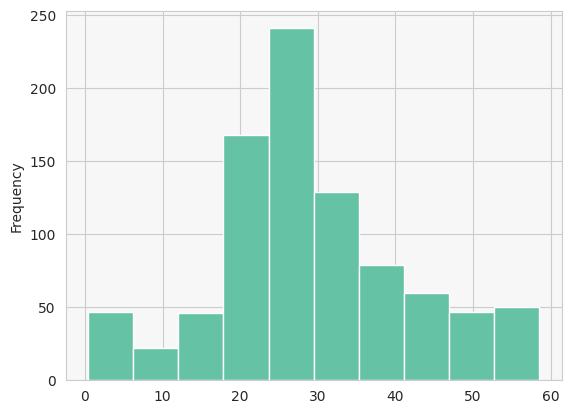

In [110]:
X.Age.plot(kind='hist')

<Axes: ylabel='Frequency'>

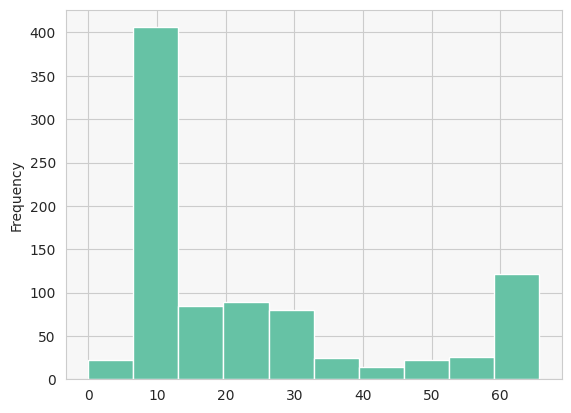

In [111]:
X.Fare.plot(kind='hist')

In [126]:
X_binned = X.copy()

In [127]:
X_binned['Age_Binned'] = pd.cut(X_binned['Age'], bins=[0, 20, 30, 40, 50, 90], labels=['<=20','20-30', '30-40', '40-50', '50+'])
X_binned['Fare_Binned'] = pd.cut(X_binned['Fare'], bins=[0, 15, 30, 45, 60, 100], labels=['<=15','15-30', '30-45', '45-60', '60+'])

In [128]:
X_binned.drop(['Age', 'Fare'], axis = 1, inplace = True)
X_binned.shape

(889, 18)

In [129]:
X_binned = pd.get_dummies(X_binned, columns=['Age_Binned', 'Fare_Binned'])
X_binned.shape

(889, 26)

In [117]:
for depth in range(1,7):
  model = DecisionTreeClassifier(max_depth = depth)
  model.fit(X_binned,y)

  print('Max_depth =',depth)
  cv_score = cross_val_score(model, X_binned, y, scoring = 'accuracy', cv=5)
  print('Cross Val:',cv_score)

  print('Train Accuracy: %.3f' % model.score(X_binned,y))
  print('Mean Validation Score : %.3f'% cv_score.mean())
  print('*'*50)

Max_depth = 1
Cross Val: [0.80337079 0.80337079 0.78651685 0.75280899 0.78531073]
Train Accuracy: 0.786
Mean Validation Score : 0.786
**************************************************
Max_depth = 2
Cross Val: [0.74719101 0.79213483 0.78651685 0.75280899 0.78531073]
Train Accuracy: 0.786
Mean Validation Score : 0.773
**************************************************
Max_depth = 3
Cross Val: [0.76404494 0.8258427  0.84269663 0.79213483 0.81920904]
Train Accuracy: 0.816
Mean Validation Score : 0.809
**************************************************
Max_depth = 4
Cross Val: [0.78089888 0.81460674 0.85955056 0.83146067 0.81355932]
Train Accuracy: 0.832
Mean Validation Score : 0.820
**************************************************
Max_depth = 5
Cross Val: [0.76966292 0.79775281 0.84269663 0.83146067 0.83050847]
Train Accuracy: 0.847
Mean Validation Score : 0.814
**************************************************
Max_depth = 6
Cross Val: [0.75280899 0.79213483 0.83707865 0.79775281 0.824

In [130]:
X_test_binned = X_test.copy()
X_test_binned['Age_Binned'] = pd.cut(X_test_binned['Age'], bins=[0, 20, 30, 40, 50, 90], labels=['<=20','20-30', '30-40', '40-50', '50+'])
X_test_binned['Fare_Binned'] = pd.cut(X_test_binned['Fare'], bins=[0, 15, 30, 45, 60, 100], labels=['<=15','15-30', '30-45', '45-60', '60+'])

X_test_binned.drop(['Age', 'Fare'], axis = 1, inplace = True)

X_test_binned = pd.get_dummies(X_test_binned, columns=['Age_Binned', 'Fare_Binned'])

X_test_binned.shape

(418, 26)

In [132]:
model = DecisionTreeClassifier(max_depth = 4)
model.fit(X_binned, y)

DecisionTreeClassifier(max_depth=4)

In [133]:
y_pred_test=model.predict(X_test_binned)

print(f"test Accuracy Score: {accuracy_score(y_true,y_pred_test):.4f}")
print(f"test Precision Score: {precision_score(y_true,y_pred_test):.4f}" )
print(f"test Recall Score: {recall_score(y_true,y_pred_test):.4f}")
print(f"test F1 Score: {f1_score(y_true,y_pred_test):.4f}")

test Accuracy Score: 0.7703
test Precision Score: 0.7333
test Recall Score: 0.5789
test F1 Score: 0.6471


In [142]:
pd.DataFrame(list(zip(X_binned.columns, model.feature_importances_)), columns=['Features', 'Importance']).sort_values(by=['Importance'], ascending=False)

,Features,Importance
4,Sex_1,0.597171
2,Pclass_3,0.149843
14,IsCabin_0,0.068352
16,Age_Binned_<=20,0.059892
13,Embarked_2,0.036919
6,SibSp_1,0.033543
19,Age_Binned_40-50,0.021290
24,Fare_Binned_45-60,0.015269
20,Age_Binned_50+,0.014671
22,Fare_Binned_15-30,0.003049


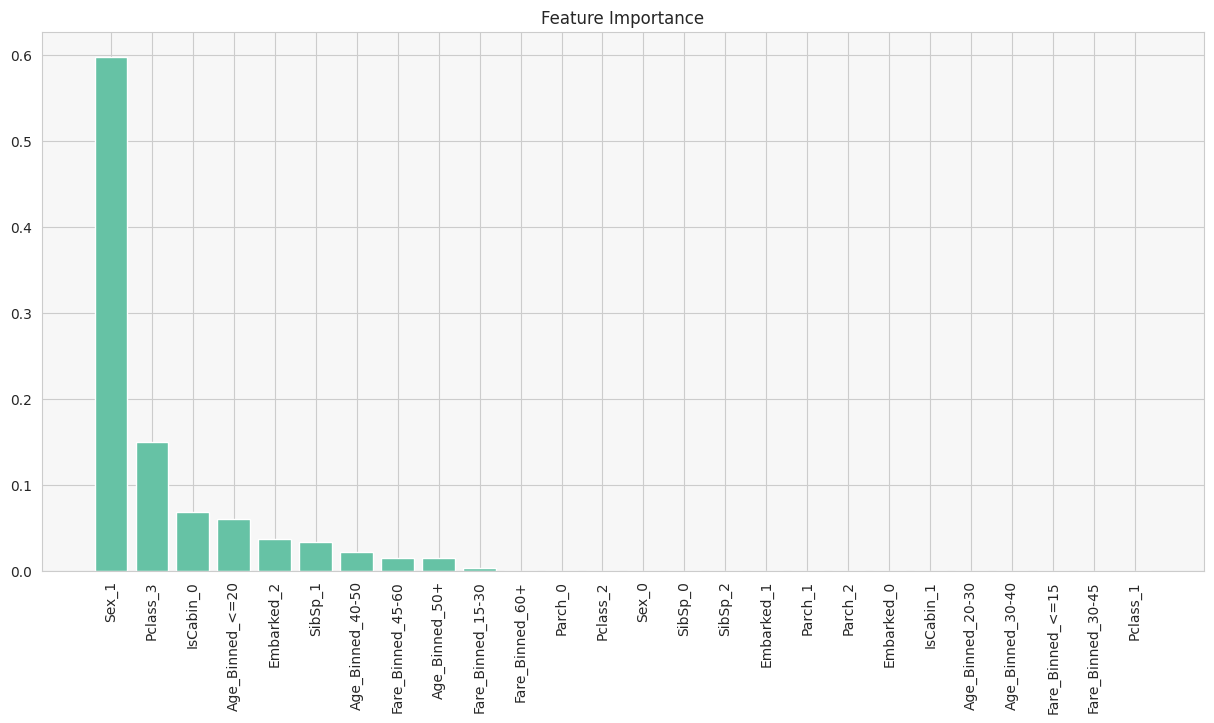

In [134]:
# Feature Importance

importances = model.feature_importances_

indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_binned.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances

plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_binned.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_binned.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

In [122]:
output =pd.DataFrame({'PassengerId' : test_data.PassengerId, 'Survived' : y_pred_test})
output.to_csv('y_pred_DecisionTree.csv', index = False)

# Random Forest

In [125]:
# import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# create instance of DT Class:
model = RandomForestClassifier(n_estimators=100, max_depth=5, criterion='gini')

# fit model
model.fit(X_binned, y)

# Calculate Train and Test Acc Scores
print("Train Acc:", model.score(X_binned, y))
print("Test Acc:", model.score(X_test_binned, y_true))

Train Acc: 0.84251968503937
Test Acc: 0.868421052631579


In [ ]:
# Defining parameters -
params = {
          'n_estimators' : [100,200,300,400],
          'max_depth' : [3,4,5],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False],
          'max_features' : [8,9,10],
          "ccp_alpha":[0.1,1,10]
}

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model = RandomForestClassifier()
grid = RandomizedSearchCV(estimator = model , # model to tuned
                    param_grid = params, # param grid
                    scoring = 'accuracy', # metric to be used for finding best value
                    cv = 3, # cross_val count
                    n_jobs=-1 # jobs to run in parrallel
                    )

In [ ]:
grid.fit(X_train, y_train)

print("Best params: ", grid.best_params_)
print("Best score: ", grid.best_score_)

Best params:  {'bootstrap': True, 'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'n_estimators': 100}
Best score:  0.7761862602500053


In [ ]:
# Feature Importance
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_

indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances

plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

# Other's Code

In [ ]:
y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = train_data[features]
X_test = test_data[features]

In [ ]:
numeric_features = ['SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
model = RandomForestClassifier(n_estimators = 100,max_depth = 5, random_state = 1)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10, 20],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}


In [ ]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

In [ ]:
train_predictions = best_model.predict(X)
train_accuracy = accuracy_score(y, train_predictions)
print("Training Accuracy:", train_accuracy*100)

Training Accuracy: 81.59371492704825


In [ ]:
output =pd.DataFrame({'PassengerId' : test_data.PassengerId, 'Survived' : predictions})
output.to_csv('submission.csv', index = False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [ ]:
y_pred_val = model.predict(X_val)

In [ ]:
print(f"Val Accuracy Score: {accuracy_score(y_val,y_pred_val):.4f}")
print(f"Val Precision Score: {precision_score(y_val,y_pred_val):.4f}" )
print(f"Val Recall Score: {recall_score(y_val,y_pred_val):.4f}")
print(f"Val F1 Score: {f1_score(y_val,y_pred_val):.4f}")

Val Accuracy Score: 0.8433
Val Precision Score: 0.8837
Val Recall Score: 0.7037
Val F1 Score: 0.7835


In [ ]:
y_pred_test=model.predict(X_test)

print(f"test Accuracy Score: {accuracy_score(y_true,y_pred_test):.4f}")
print(f"test Precision Score: {precision_score(y_true,y_pred_test):.4f}" )
print(f"test Recall Score: {recall_score(y_true,y_pred_test):.4f}")
print(f"test F1 Score: {f1_score(y_true,y_pred_test):.4f}")

test Accuracy Score: 0.8517
test Precision Score: 0.8571
test Recall Score: 0.7105
test F1 Score: 0.7770


In [ ]:
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier()

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred_val = model.predict(X_val)
print(f"Val Accuracy Score: {accuracy_score(y_val,y_pred_val):.4f}")
print(f"Val Precision Score: {precision_score(y_val,y_pred_val):.4f}" )
print(f"Val Recall Score: {recall_score(y_val,y_pred_val):.4f}")
print(f"Val F1 Score: {f1_score(y_val,y_pred_val):.4f}")

Val Accuracy Score: 0.8060
Val Precision Score: 0.7692
Val Recall Score: 0.7407
Val F1 Score: 0.7547


In [ ]:
y_pred_test=model.predict(X_test)

print(f"test Accuracy Score: {accuracy_score(y_true,y_pred_test):.4f}")
print(f"test Precision Score: {precision_score(y_true,y_pred_test):.4f}" )
print(f"test Recall Score: {recall_score(y_true,y_pred_test):.4f}")
print(f"test F1 Score: {f1_score(y_true,y_pred_test):.4f}")

test Accuracy Score: 0.7656
test Precision Score: 0.6687
test Recall Score: 0.7039
test F1 Score: 0.6859


In [ ]:
params = {
    "n_estimators": [50,100,150,200],
    "max_depth" : [3, 4, 5, 7],
    "max_leaf_nodes" : [20, 40, 80],
}
model = xgb.XGBClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from time import time
start = time() # log the starting time
# define randomsearch cv
cls=RandomizedSearchCV(model, params, scoring = "accuracy", cv=3,
                       n_jobs = -1, verbose = 1,n_iter=2) # reduced iteration to sample parameters as well as cv size
cls.fit(X_train, y_train)
end = time() # logs the end time
print("Time Taken:", end-start) # Total time taken

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Time Taken: 7.365683078765869


In [ ]:
res = cls.cv_results_
for i in range(len(res["params"])):
  print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

Parameters:{'n_estimators': 100, 'max_leaf_nodes': 80, 'max_depth': 5} Mean_score: 0.8185564619827569 Rank: 1
Parameters:{'n_estimators': 100, 'max_leaf_nodes': 40, 'max_depth': 5} Mean_score: 0.8185564619827569 Rank: 1


In [ ]:
best_model = xgb.XGBClassifier()

NameError: name 'fit_and_return_model' is not defined